In [1]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
import gzip
from tqdm import tqdm_notebook
from functools import reduce
from scipy.stats import norm as normalDist
from scipy.stats import multivariate_normal as MVNormalDist
colors = sns.cubehelix_palette(12)#sns.color_palette("husl",12)
from matplotlib.lines import Line2D
import matplotlib

In [3]:
idx = pd.IndexSlice
rc = ipp.Client()#('/home/julian/.ipython/profile_ssh/security/ipcontroller-client.json')
dview = rc.load_balanced_view()
print(rc.ids)
sns.set_style("whitegrid")

def send_file(dview, local_path, remote_path):
    """Send a single file"""
    print("sending file", local_path, remote_path)
    import io, os
    
    def _recv(remote_path, bdata, mtime):
        import io, os
        if os.path.exists(remote_path):
            os.unlink(remote_path)
        with io.open(remote_path, 'wb') as f:
            f.write(data)
        os.utime(remote_path, (mtime, mtime))
    
    st = os.stat(local_path)
    with io.open(local_path, 'rb') as f:
        data = f.read()
    
    yield dview.apply_async(_recv, remote_path, data, st.st_mtime)
    
#TODO: use chrpath PyVal.so -r . to make libtrng visible
#for el in send_file(dview, '../build/PyVal.cpython-36m-x86_64-linux-gnu.so','./PyVal.so'):
    
    print(el.get())
for el in send_file(dview, '../external/lib/libtrng4.so.19', './libtrng4.so.19'):
    pass
for el in send_file(dview, '../external/lib/libtrng4.so', './libtrng4.so'):
    pass

with rc[:].sync_imports():
    import PyVal
    import numpy as np


[0, 1, 2, 3, 4, 5, 6, 7]
sending file ../external/lib/libtrng4.so.19 ./libtrng4.so.19
None
sending file ../external/lib/libtrng4.so ./libtrng4.so
None
importing PyVal on engine(s)
importing numpy on engine(s)


/home/julian/.local/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@julian-ThinkPad-W530')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [134]:
%run "functions.py"

# Fixed

In [5]:
def fp(M, x, a_, d):
    N = M.shape[0]
    for i in range(100):
        xp = M.dot(x)
        x[:N] = np.maximum(0., a_ + xp - d)
        x[N:] = np.minimum(d, a_ + xp)
    return x
def sol_to_c(sol):
    if(sol[0] and sol[1]):
        return colors[0]
    if(sol[0] and not sol[1]):
        return colors[4]
    if(not sol[0] and sol[1]):
        return colors[7]
    if(not sol[0] and not sol[1]):
        return colors[10]
    
def run_sim(M, x, a, d):
    res = []
    for ai in a:
        r = fp(M, x, ai, d)
        res.append(np.copy(r))
    return np.array(res)

In [104]:
Nsamples = 500000
r  = 0.
T  = 1.
N_MC = 500000
N = 2
df_scale = 1.0
netType = 1
vs01_vals = np.array([0.,0.2, 0.6, 0.8])
vs10_vals = np.array([0.,0.2, 0.6, 0.8])
vr01_vals = np.array([0.,0.2, 0.6, 0.8])
vr10_vals = np.array([0.,0.2, 0.6, 0.8])
S0_vals   = np.linspace(0., 2.0, 40)
sigma_vals = [0.2]#[0.1, 0.2, 0.3]
r_vals    = [0.0]#[0., 0.1, 0.2]
T_vals    = [1.]#[0.1, 1.0, 2.0]
param_grid = [(N_MC, N, T, r, S0, sigma, df_scale, vs01, vs10, vr01, vr10) \
             for T in T_vals for r in r_vals for S0 in S0_vals for sigma in sigma_vals\
             for vs01 in vs01_vals for vs10 in vs10_vals for vr01 in vr01_vals for vr10 in vr10_vals]
len(param_grid)

10240

In [105]:
async_res = []
ids = []
for el in param_grid:
    with dview.temp_flags(retries=2):
        b_re = dview.apply_async(run_fixed_sim, *el)
        async_res.append(b_re)
        ids.extend(b_re.msg_ids)
filename = "2d_test_2"

In [144]:
done = 0
waiting = 0
for el in async_res:
    if el.progress == 1:
        done += 1
    else:
        waiting += 1
print(str(done) + "/"+str(waiting+done) + " complete")
#param_grid_ER_no_suppression

1001/10240 complete


In [143]:
print('unfinished jobs: '+ str(len(rc.result_status(ids)['pending'])) + '/' + str(len(rc.result_status(ids)['completed']) + len(rc.result_status(ids)['pending'])) + str('. Running on ') + str(len(rc.ids)) + ' nodes')

unfinished jobs: 9293/10240. Running on 8 nodes


# Save

In [101]:
f_content = [r.get() for r in async_res]
df = results_to_df(f_content, netType)
df2, df2_debug = reduce_to_scalars(df, 2, 10., 1)
df2.to_csv(filename+'.csv', index=False)
#df.set_index(indices,inplace=True)

In [21]:
print(df['Delta'][30][:,:])
print(df['Vega'][30][:,:])
print(df['Theta'][30][:,:])
print(df['Rho'][30][:,:])

[[0.         0.         1.00239889 0.        ]
 [0.         0.         0.60223941 1.00373235]]
[[0.         0.         0.00171395 0.00156729]
 [0.         0.         0.         0.        ]]
[[0.         0.         0.00251379 0.00229869]]
[[0. 0. 0. 0.]]


In [35]:
print(df2['equity Delta'][30])
print(df2['debt Delta'][30])
print(df2['equity Vega'][30])
print(df2['debt Vega'][30])
print(df2['equity Theta'][30])
print(df2['debt Theta'][30])
print(df2['equity Rho'][30])
print(df2['debt Rho'][30])

0.0
1.3016493924720445
0.0
0.1080506152533366
0.0
0.008330611162130352
0.0
0.0


# Retrieve

In [97]:
#inf = open('param_grid_ER_5x_ds_vs_w.pkl', 'rb') #'res_0_1_newnew.pkl'
df1 = pd.read_csv(filename+'.csv')
df_scales = np.unique(df1['default scale'])
#col_sums = np.unique(df1['col sum'])  
sigma_vals = np.unique(df1['sigma'])  
spot_prices = np.unique(df1['S0'])    
df1.set_index(['N', 'sigma', 'default scale', 'r', 'S0', 'vs01', 'vs10', 'vr01', 'vr10'], inplace=True)
#df1.reset_index([0,2,3]).index.values

# Plots
## Plot 2D

In [110]:
sigma_select = 0.2
r_select = 0.0
df2.set_index(['N', 'sigma', 'default scale', 'r', 'S0', 'vs01', 'vs10', 'vr01', 'vr10'], inplace=True)
df_greeks = df2.loc[2,sigma_select,1.0,r_select,:,0.,0.,:,:,:][['equity Delta', 'debt Delta', 'equity Vega', 'debt Vega',
                            'equity Theta', 'debt Theta', 'equity Rho', 'debt Rho']]
df_greeks_var = df2.loc[2,sigma_select,1.0,r_select,:,0.,0.,:,:,:][['equity Delta var', 'debt Delta var', 
                                                                    'equity Vega var', 'debt Vega var',
                            'equity Theta var', 'debt Theta var', 'equity Rho var', 'debt Rho var']]
S0 = np.unique(df_greeks.index.get_level_values('S0').values)
M_vals = np.unique(df_greeks.reset_index(level=0).index.values)

<IPython.core.display.Javascript object>


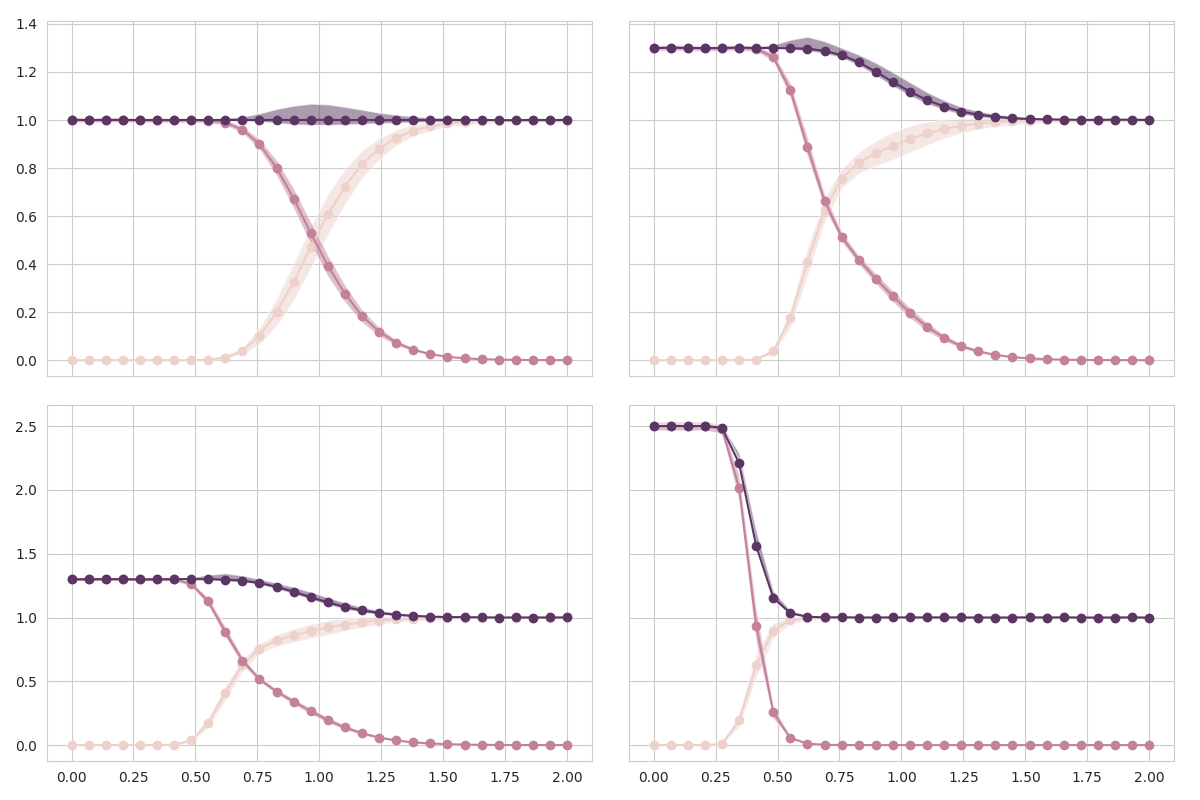

/home/julian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/julian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: PerformanceWarning: indexing past lexsort depth may impact performance.


<IPython.core.display.Javascript object>


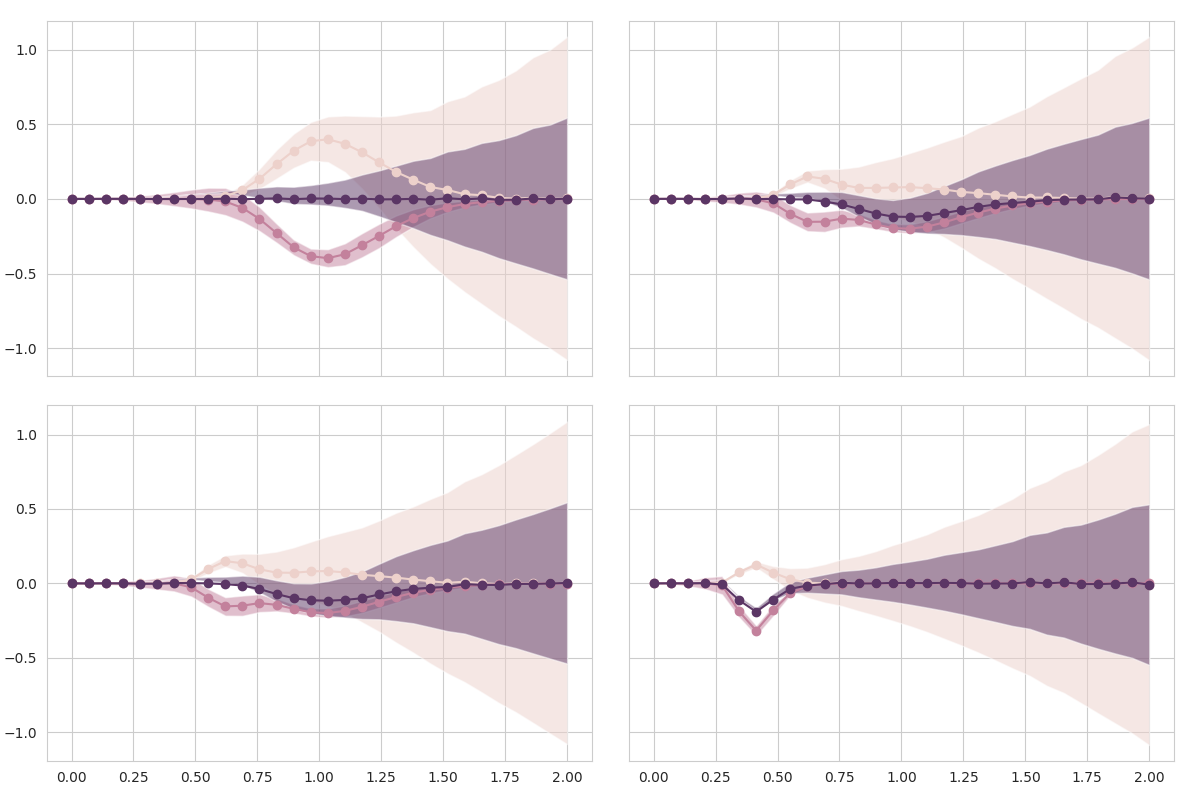

<IPython.core.display.Javascript object>


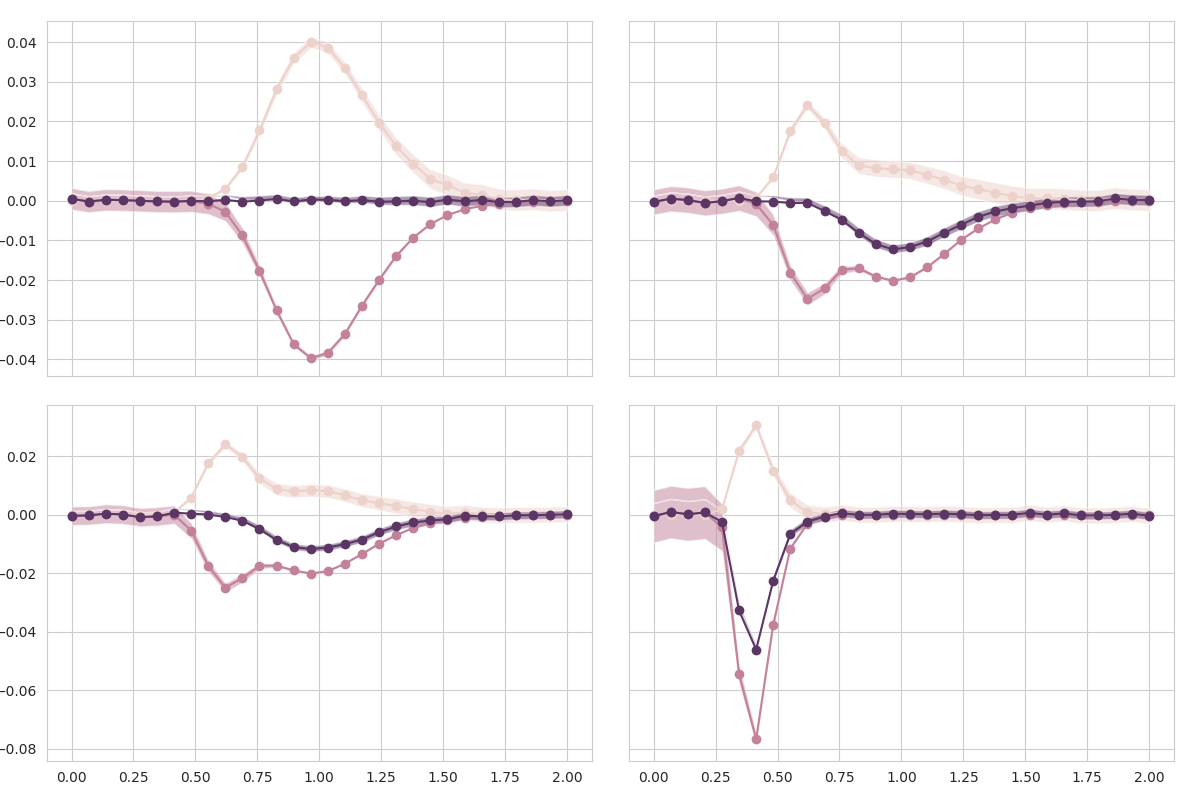

<IPython.core.display.Javascript object>


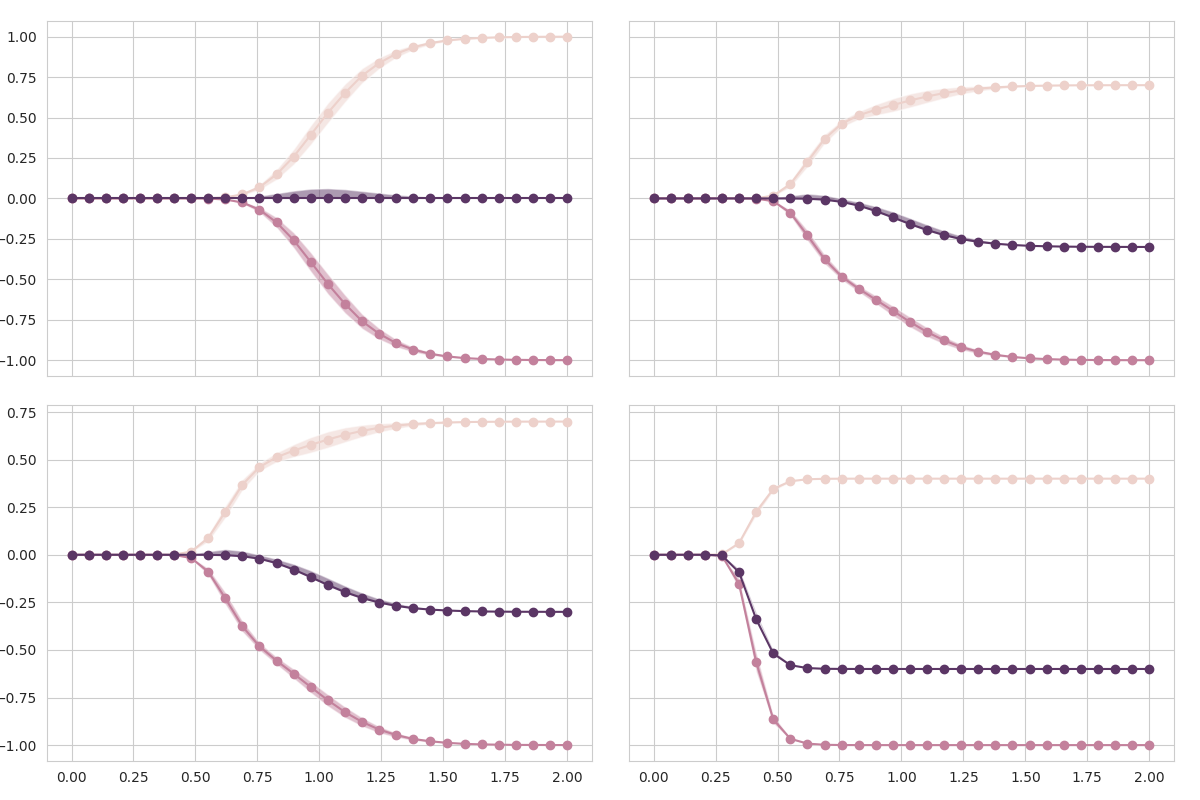

In [130]:
nplots = df2.index.levshape[5]
atl2 = S0
vr01l = np.unique(df_greeks.index.get_level_values('vr01').values)#np.unique(df1['vr10'].values)#np.linspace(0.,0.8, nplots)
vr10l = np.unique(df_greeks.index.get_level_values('vr10').values)#np.unique(df1['vs10'].values)#np.linspace(0.,0.8, nplots)
#d = 1.0
#tau = 1.0
#sigma = 0.1
#r = 0.2

#cols = ['$w^d$ = {0:.1f}'.format(col) for col in wdl]
#rows = ['$w^s$ = {0:.1f}'.format(col) for col in wsl]
greek_str = [r'$\Delta_s$',r'$\Delta_r$',r'$\Delta$', 
             r'$\nu_s$' ,  r'$\nu_r$' ,  r'$\nu$' ,
             r'$\Theta_s$',r'$\Theta_r$',r'$\Theta$',
             r'$\rho_s$',  r'$\rho_r$',  r'$\rho$']

var_r = True

for greek in range(4):
    f2, axarr2 = plt.subplots(len(vr01l),len(vr10l), figsize=(12, 8) ,sharex='col', sharey='row')
    #for ax, col in zip(axarr2[0], cols):
    #    ax.set_title(col)
    #for ax, col in zip(axarr2[-1], cols):
    #    ax.set_xlabel('spot price')
    #for ax, row in zip(axarr2[:,-1], rows):
    #    ax.set_ylabel(row, rotation=90, size='large')
    #    ax.yaxis.set_label_position("right")
        
    f2.tight_layout()
    for i,vr01_val in enumerate(vr01l):
        for j,vr10_val in enumerate(vr10l):
            atl = S0#np.clip(atl2,0., 1.5*(1.0-wd))
            gr = df_greeks.reset_index(level=0,drop=True).loc[vr01_val, vr10_val].values
            gr_var = df_greeks_var.reset_index(level=0,drop=True).loc[vr01_val, vr10_val].values
            gr_var = gr_var/(N*N)#np.clip(, 0., 1.)
            ind = 2*greek
            sline = axarr2[i,j].plot(atl,gr[:,ind], marker='o', color=colors[0]) #
            axarr2[i,j].fill_between(atl, gr[:,ind]+gr_var[:,ind], gr[:,ind]-gr_var[:,ind],
                                      facecolor=colors[0], alpha=0.5)
            ind = 2*greek+1
            rline = axarr2[i,j].plot(atl,gr[:,ind], marker='o', color=colors[4]) #
            axarr2[i,j].fill_between(atl, gr[:,ind]+gr_var[:,ind], gr[:,ind]-gr_var[:,ind],
                                      facecolor=colors[4], alpha=0.5)
            vline = axarr2[i,j].plot(atl,gr[:,ind-1] + gr[:,ind], marker='o', color=colors[9]) #
            axarr2[i,j].fill_between(atl,gr[:,ind-1] + gr[:,ind]+(gr_var[:,ind-1]+gr_var[:,ind])/2,
                                     gr[:,ind-1] + gr[:,ind]-(gr_var[:,ind-1]-gr_var[:,ind])/2,
                                      facecolor=colors[9], alpha=0.5)
            #sline2 = axarr2[i,j].plot(atl,gr2[0,greek,:], color=colors[1])
            #rline2 = axarr2[i,j].plot(atl,gr2[1,greek,:], color=colors[5])
            #vline2 = axarr2[i,j].plot(atl,gr2[0,greek,:] + gr2[1,greek,:], color=colors[10])
            #sline3 = axarr2[i,j].plot(atl,gr3[0,greek,:], color=colors[2])
            #rline3 = axarr2[i,j].plot(atl,gr3[1,greek,:], color=colors[6])
            #vline3 = axarr2[i,j].plot(atl,gr3[0,greek,:] + gr3[1,greek,:], color=colors[11])
            #axarr[i,j].legend()
            #axarr2[i,j].set_ylim(top=2.5)

    proxy_lines2 = [matplotlib.lines.Line2D([], [], color=p) for p in [colors[0], colors[1], colors[2], colors[4], colors[5], colors[6],
                                                                     colors[9], colors[10], colors[11]]]

    #f2.legend((sline, rline, vline), ('equity', 'r', 'v = s+r'))
    #f2.savefig('greeks_2D_'+str(greek)+'_varr', bbox_extra_artists=(lgd2,), bbox_inches="tight")
    del f2, axarr2, proxy_lines2 #lgd2, 

In [ ]:
    if var_r:
        lgd2 = f2.legend(proxy_lines2, [greek_str[3*greek]+r' for $r = 0$', greek_str[3*greek]+r' for $r = 0.1$',
                                 greek_str[3*greek]+r' for $r = 0.2$',
                                 greek_str[3*greek+1]+r' for $r = 0$', greek_str[3*greek+1]+r' for $r = 0.1$',
                                 greek_str[3*greek+1]+r' for $r = 0.2$',
                                 greek_str[3*greek+2]+r' for $r = 0$', greek_str[3*greek+2]+r' for $r = 0.1$',
                                 greek_str[3*greek+2]+r' for $r = 0.2$'
                                ], loc='lower center', fancybox=False, shadow=False, ncol=3,
             bbox_transform=f2.transFigure, bbox_to_anchor=(0.5,-0.09))
    else:
        lgd2 = f2.legend(proxy_lines2, [greek_str[3*greek]+r' for $\sigma = 0.1$', greek_str[3*greek]+r' for $\sigma = 0.2$',
                                 greek_str[3*greek]+r' for $\sigma = 0.3$',
                                 greek_str[3*greek+1]+r' for $\sigma = 0.1$', greek_str[3*greek+1]+r' for $\sigma = 0.2$',
                                 greek_str[3*greek+1]+r' for $\sigma = 0.3$',
                                 greek_str[3*greek+2]+r' for $\sigma = 0.1$', greek_str[3*greek+2]+r' for $\sigma = 0.2$',
                                 greek_str[3*greek+2]+r' for $\sigma = 0.3$'],
                                 loc='lower center', fancybox=False, shadow=False, ncol=3,
                                    bbox_transform=f2.transFigure, bbox_to_anchor=(0.5,-0.09))

In [ ]:
#inf = open('param_grid_ER_5x_ds_vs_w.pkl', 'rb') #'res_0_1_newnew.pkl'
df1 = pd.read_csv(filename+'.csv')
df_scales = np.unique(df1['default scale'])
col_sums = np.unique(df1['col sum'])  
sigma_vals = np.unique(df1['sigma'])  
spot_prices = np.unique(df1['S0'])    
df1.set_index(['N', 'sigma','col sum', 'default scale', 'r', 'S0'], inplace=True)
#df1.reset_index([0,2,3]).index.values

In [176]:
N = 80
val = 0.1
ds = 1.0
r = 0.0
S0 = 0.25
data = df3.loc[idx[N,:,val, ds, r, S0],['equity Delta','equity Delta var','debt Delta','debt Delta var', 'Number Of Samples']]

/home/jstobbe/ipcluster_1/ipcluster_1/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


<IPython.core.display.Javascript object>


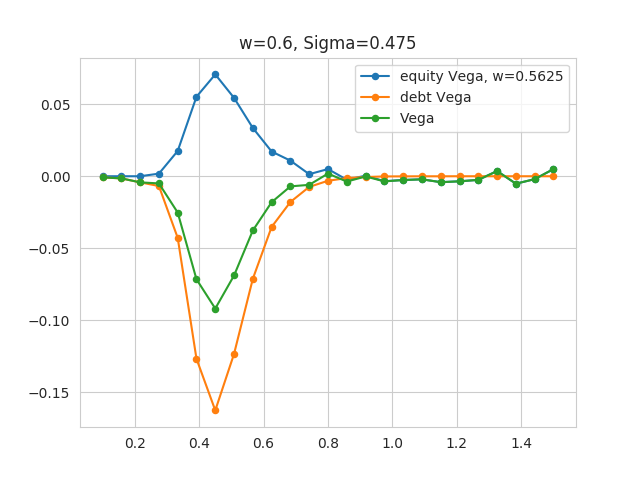

In [63]:
sns.set_style("whitegrid")
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)

def plot_val(l, ax, val, ds, S0, sigma, greek , title=""):
    nl = np.unique(l.reset_index(level=[1,2,3,4,5]).index.values)
    rl = np.unique(df1.reset_index()['r'])
    N = 2
    for r in rl:
        for w in col_sums[15:16]:
            c = next(ccycle)
            data = l.loc[idx[N, sigma ,w, ds, r, :],['equity ' + greek,'equity ' +greek+ ' var','debt '+greek,\
                                                  'debt '+greek+' var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Vega','Vega var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Solvent', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['RS', 'Number Of Samples']]
            n_samples = np.sqrt(np.array([ el for el in data['Number Of Samples'].values]))
            x = l.loc[idx[N, sigma, val, ds, r, :],:].reset_index([0,1,2,3,4]).index.values
            y = np.array([np.sum(el)/(float(N)) for el in data['equity '+greek].values])
            y2 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values])
            y3 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values+data['equity '+greek].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Delta var'].values])/n_samples
            #y = np.array([np.sum(el[:N]+el[N:])/(float(N)) for el in data['RS'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Solvent'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Vega'].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Vega var'].values])/n_samples
            ii = np.argsort(x)
            x = x[ii]
            y = y[ii]
            #y_err = y_err[ii]
            #sns.lineplot(x,y, ax = ax)
            ax.plot(x,y, marker='o', markersize=4.4, label="equity "+greek+", w=" + str(w))
            ax.plot(x,y2, marker='o', markersize=4.4, label="debt "+greek)
            ax.plot(x,y3, marker='o', markersize=4.4, label=greek)
            #ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
            if title:
                ax.set_title(title)
            else:
                ax.set_title(r'$\sum_j M_{ij} = $' + str(val) +" sigma " +str(sigma))
            ax.legend()
      
#fig, axs = plt.subplots(nrows=len(col_sums), ncols=len(sigma_vals), sharex=True, sharey=False, figsize=(7*len(df_scales), 10*len(col_sums)))
#for ic, val in enumerate(col_sums):
#    for ir, sp in enumerate(sigma_vals):
#        ax = axs[ic,ir]
fix, ax = plt.subplots(nrows = 1, ncols = 1)
val = 0.6
sp = sigma_vals[3]
greek = "Vega"
plot_val(df1 ,ax, val, 1.0, -1, sp, greek ,"w=" + str(val) + ", Sigma=" + str(sp))

#axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#plt.errorbar(x, y, yerr=y_err, fmt='o')

plt.show()

# Replication: Distortion of lognormal

<IPython.core.display.Javascript object>


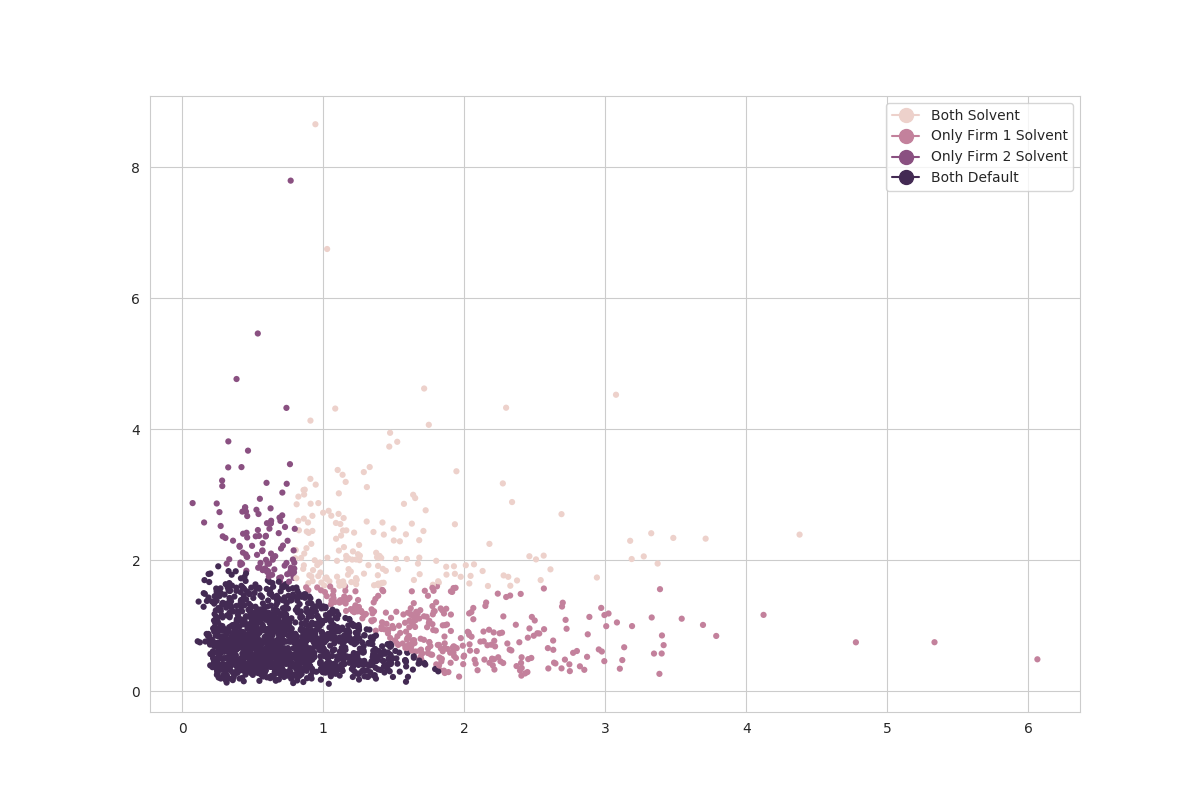

<IPython.core.display.Javascript object>


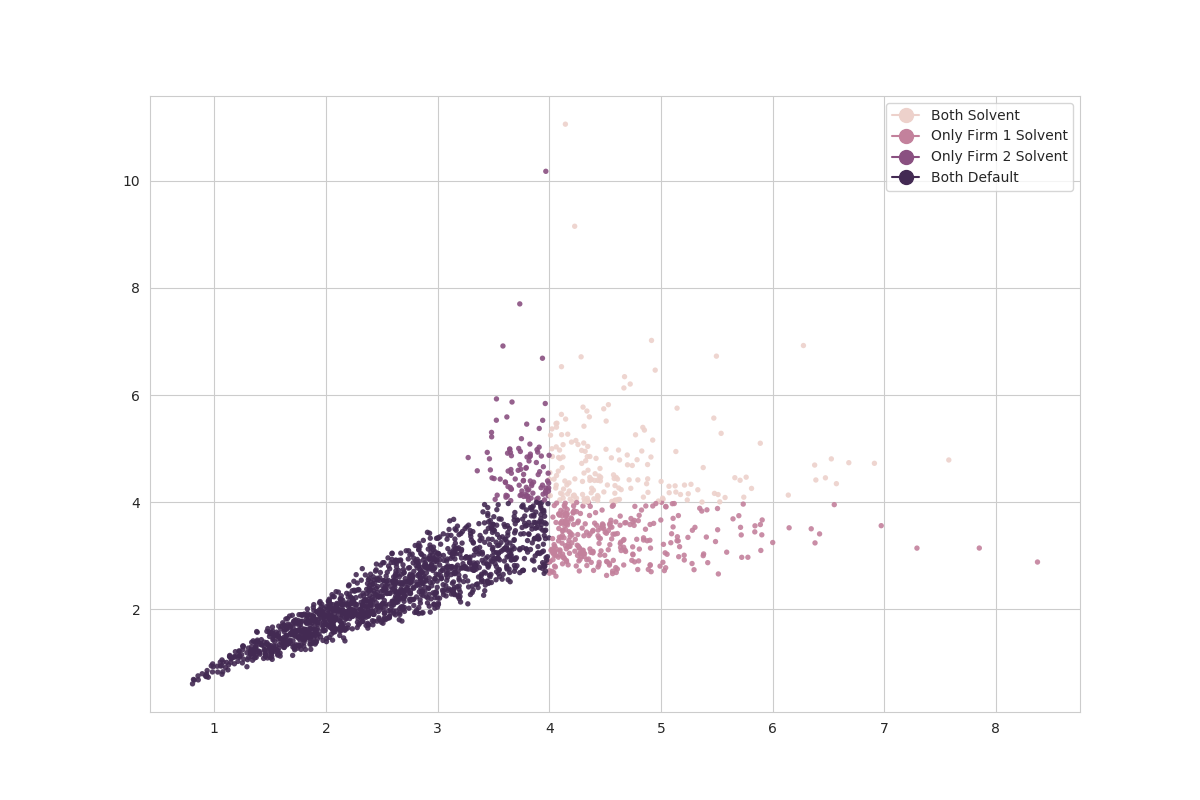

In [655]:

def plot_scatter(v, d):
    solvent = np.greater(v,d)
    cm = np.apply_along_axis(sol_to_c, 1, solvent)
    plt.scatter(v[:,0], v[:,1], c=cm, s = 15, alpha=0.9, edgecolors='none')

Nsamples = 2000
S0 = 1.0#np.linspace(0.,1.5, Nsamples)
r  = 0.
T  = 1.
wd = 0.9

M  = np.array([[0.,0.0,0., 0.8],[0.0,0.,0.6, 0.]])
x  = np.array([1.,1.,1.,1.])

sigma = np.array([[0.4, 0.],[0., 0.4]])
var_h = r*T - T*np.diag(sigma)/2.
Z = MVNormalDist([0.,0.],np.eye(2)).rvs(Nsamples)
d  = 0.4/(1.-wd)
al  = S0*np.exp(var_h + np.sqrt(T) * np.sqrt(np.diag(sigma)) * Z)


X,Y = np.meshgrid(np.linspace(0.,6.,70),np.linspace(0.,6.,70))
a = np.vstack((X.flatten(), Y.flatten())).T

X,Y = np.meshgrid(np.linspace(1.,1.2,30),np.linspace(2.,2.2,30))
a2 = np.vstack((X.flatten(), Y.flatten())).T

X,Y = np.meshgrid(np.linspace(4.0,4.2,30),np.linspace(3.2,3.4,30))
a3 = np.vstack((X.flatten(), Y.flatten())).T

X,Y = np.meshgrid(np.linspace(1.4,1.6,30),np.linspace(5.0,5.2,30))
a4 = np.vstack((X.flatten(), Y.flatten())).T

X,Y = np.meshgrid(np.linspace(4.0,4.2,30),np.linspace(5.0,5.2,30))
a5 = np.vstack((X.flatten(), Y.flatten())).T

X,Y = np.meshgrid(np.linspace(.9,1.1,30),np.linspace(3.9,4.1,30))
a6 = np.vstack((X.flatten(), Y.flatten())).T




res = run_sim(M, x, al, d)
v = (res[:, :2] + res[:, 2:])
res2 = run_sim(M, x, a2, d)
v2 = (res2[:, :2] + res2[:, 2:])
res3 = run_sim(M, x, a3, d)
v3 = (res3[:, :2] + res3[:, 2:])
res4 = run_sim(M, x, a4, d)
v4 = (res4[:, :2] + res4[:, 2:])
res5 = run_sim(M, x, a5, d)
v5 = (res5[:, :2] + res5[:, 2:])
res6 = run_sim(M, x, a6, d)
v6 = (res6[:, :2] + res6[:, 2:])


f = plt.figure(figsize=(12, 8))
solvent = np.greater(v,d)
cm = np.apply_along_axis(sol_to_c, 1, solvent)
plt.scatter(al[:,0], al[:,1], c=cm, s = 20,alpha=1.0, edgecolors='none')
#plt.scatter(a2[:,0], a2[:,1], c=colors[10], s = 1,alpha=0.9, edgecolors='none')
#plt.scatter(a3[:,0], a3[:,1], c=colors[4], s = 1,alpha=0.9, edgecolors='none')
#plt.scatter(a4[:,0], a4[:,1], c=colors[7], s = 1,alpha=0.9, edgecolors='none')
#plt.scatter(a5[:,0], a5[:,1], c=colors[0], s = 1,alpha=0.9, edgecolors='none')
#plt.scatter(a6[:,0], a6[:,1], c=colors[0], s = 1,alpha=0.9, edgecolors='none')
legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='Both Solvent',
                          markerfacecolor=colors[0], markersize=10),
                  Line2D([0], [0], marker='o', color=colors[4], label='Only Firm 1 Solvent',
                          markerfacecolor=colors[4], markersize=10)
                  ,
                  Line2D([0], [0], marker='o', color=colors[7], label='Only Firm 2 Solvent',
                          markerfacecolor=colors[7], markersize=10),
                  Line2D([0], [0], marker='o', color=colors[10], label='Both Default',
                          markerfacecolor=colors[10], markersize=10)]
plt.legend(handles=legend_elements)

f2 = plt.figure(figsize=(12, 8))
plot_scatter(v,d)
#plot_scatter(v2,d)
#plot_scatter(v3,d)
#plot_scatter(v4,d)
#plot_scatter(v5,d)
plt.legend(handles=legend_elements)
#plt.figure()
#plot_scatter(v6,d)

f.savefig('distortion_l_01')
f2.savefig('distortion_l_02')

#plt.figure()
#for i in range(0, v.shape[0]):
#    plt.plot(a[i,:], v[i,:], '-')
#lv = np.array([v[:,0]/10.-a[:,0], v[:,1]/10.-a[:,1]]).T
#len_lv = np.sqrt(lv[:,0]*lv[:,0] + lv[:,1]*lv[:,1])
#plt.xlim(right=np.max(v[:,0])+np.max(a[:,0]))
#plt.ylim(top=np.max(v[:,1])+np.max(a[:,1]))
#a[:,0], a[:,1],lv[:,0], lv[:,1]
#plt.quiver(a[:,0], a[:,1],lv[:,0], lv[:,1],angles='xy', scale_units='xy', scale=1., color=cm, alpha=0.3)